Imports.

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.io
from skbeam.core.utils import q_to_twotheta
import fabio
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

Please state the format of the files to be integrated, e.g., `tif` or `npy`.  
Also, please state the output format, e.g., `chi`, `dat`, `xy`.

In [2]:
input_format = "tif"
output_format = "chi"

Creating directories for input files:
- `*input_format*` for input files to be integrated. Stated above.
- `*input_format*_bkg` for background file. 
- `*input_format*_calib` for crystalline standard for calibration file.

In [3]:
input_path = Path.cwd() / input_format
input_bkg_path = Path.cwd() / f"{input_format}_bkg"
input_calib_path = Path.cwd() / f"{input_format}_calib"
input_paths = [input_path, input_bkg_path, input_calib_path]
for p in input_paths:
    if not p.exists():
        p.mkdir()
        print(f"{80*'-'}\nA folder called '{p.name}' has been created.\n"
              f"Please put the appropriate .{input_format} file(s) in the "
              f"folder before proceeding."
              )

Checking whether input files are present in the input folders and collecting
them if they are.

In [4]:
inputs_all_not_found = False
for p in input_paths:
    if len(list(p.glob(f"*.{input_format}"))) == 0:
        inputs_all_not_found = True
        print(f"{80*'-'}\nNo .{input_format} files were found in the "
              f"'{p.name}' folder.\nPlease place the appropriate "
              f".{input_format} file(s) and rerun before proceeding."
              )
if inputs_all_not_found:
    sys.exit()
else:
    input_files = list(input_path.glob(f"*.{input_format}"))
    input_bkg_file = list(input_bkg_path.glob(f"*.{input_format}"))[0]
    input_calib_file = list(input_calib_path.glob(f"*.{input_format}"))[0]
    print(f"{80*'-'}\nInput files collected.\n{80*'-'}")

--------------------------------------------------------------------------------
Input files collected.
--------------------------------------------------------------------------------


Creating directories for output files from calibration in pyFAI (below.)
- `npy_mask` for .npy file for static mask during calibration.
- `npt_calib` for .npt file containing azimuthal rings used for calibration.
- `poni_calib` for the .ponu file containing the experimental geometry obtained
  from the calibration.

In [5]:
npy_mask_path = Path.cwd() / "npy_mask"
npt_calib_path = Path.cwd() / "npt_calib"
poni_calib_path = Path.cwd() / "poni_calib"
calib_paths = [npy_mask_path, npt_calib_path, poni_calib_path]
for p in calib_paths:
    if not p.exists():
        p.mkdir()
        print(f"{80*'-'}\nA folder called '{p.name}' has been created.\n"
              f"Please save a .{p.name.split('_')[0]} file in the folder "
              f"during the calibration in pyFAI (below)."
              )        

In [6]:
! pyfai-calib2

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pyFAI.method_registry:Degrading method from Method(dim=1, split='pseudo', algo='histogram', impl='*', target=None) -> Method(dim=1, split='bbox', algo='histogram', impl='*', target=None)


Collecting calibration files.

In [7]:
calibs_all_not_found = False
calib_paths = [npy_mask_path, poni_calib_path]
for p in calib_paths:
    if len(list(p.glob(f"*.{p.name.split('_')[0]}"))) == 0:
        calibs_all_not_found = True
        print(f"{80*'-'}\nNo .{p.name.split('_')[0]} file was found in the "
              f"'{p.name}' folder.\nPlease place the appropriate "
              f".{p.name.split('_')[0]} file and rerun before proceeding."
              )
if calibs_all_not_found:
    print(f"{80*'-'}")
    sys.exit()
else:
    npy_mask_file = list(npy_mask_path.glob(f"*.npy"))[0]
    poni_file = list(poni_calib_path.glob(f"*.poni"))[0]
    print(f"{80*'-'}\nCalibration files collected.\n{80*'-'}")

--------------------------------------------------------------------------------
Calibration files collected.
--------------------------------------------------------------------------------


Converting static mask from .npy format to .msk fotmat. (Fit2D mask, which is 
also compatible with the DAWN software package.)

In [8]:
msk_static_path = Path.cwd() / "msk_static"
if not msk_static_path.exists():
    msk_static_path.mkdir()
msk_static_output = msk_static_path / f"{npy_mask_file.stem}.msk"
fabio.open(npy_mask_file).convert("msk").save(msk_static_output)

Creating output drectories.
- `*output_format*` for azimuthally integrated files. Stated above.
- `*output_format*_bkg` for azimuthally integrated background file.
- `*output_format*_calib` for azimuthally integrated calibration file.

In [9]:
output_path = Path.cwd() / output_format
output_bkg_path = Path.cwd() / f"{output_format}_bkg"
output_calib_path = Path.cwd() / f"{output_format}_calib"
output_paths = [output_path, output_bkg_path, output_calib_path]
for p in output_paths:
    if not p.exists():
        p.mkdir()
        print(f"{80*'-'}\nA folder called '{p.name}' has been created for "
              f"azimuthally integrated .{output_format} file(s)."
              )    

Imports and function definitions for automasking and integration.

Adopted from: https://github.com/st3107/masking

In [10]:
from typing import Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed
from numpy import ndarray
from numba import jit, boolean
from skbeam.core.accumulators.binned_statistic import BinnedStatistic1D
from skbeam.core.mask import margin

@jit(cache=True, nopython=True, nogil=True)
def mask_ring_median(values_array, positions_array, alpha):  # pragma: no cover
    """Find outlier pixels in a single ring via a single pass with the median.

    Parameters
    ----------
    values_array : ndarray
        The ring values
    positions_array : ndarray
        The positions of the values
    alpha: float
        The threshold

    Returns
    -------
    removals: np.ndarray
        The positions of pixels to be removed from the data
    """
    z = np.abs(values_array - np.median(values_array)) / np.std(values_array)
    removals = positions_array[np.where(z > alpha)]
    return removals


@jit(cache=True, nopython=True, nogil=True)
def mask_ring_mean(values_array, positions_array, alpha):  # pragma: no cover
    """Find outlier pixels in a single ring via a pixel by pixel method with
    the mean.

    Parameters
    ----------
    values_array : ndarray
        The ring values
    positions_array : ndarray
        The positions of the values
    alpha: float
        The threshold

    Returns
    -------
    removals: np.ndarray
        The positions of pixels to be removed from the data
    """
    m = np.ones(positions_array.shape, dtype=boolean)
    removals = []
    while True:
        b = np.array(
            [item in removals for item in positions_array], dtype=boolean
        )
        m[b] = False
        v = values_array[m]
        if len(v) <= 1:
            break
        std = np.std(v)
        if std == 0.0:
            break
        norm_v_list = np.abs(v - np.mean(v)) / std
        if np.all(norm_v_list < alpha):
            break
        # get the index of the worst pixel
        worst_idx = np.argmax(norm_v_list)
        # add the worst position to the mask
        removals.append(positions_array[m][worst_idx])
    return removals


mask_ring_dict = {"median": mask_ring_median, "mean": mask_ring_mean}

def map_to_binner(pixel_map, bins, mask=None):
    """Transforms pixel map and bins into a binner

    Parameters
    ----------
    pixel_map: np.ndarray
        The map between pixels and values
    bins: np.ndarray
        The bins to use in the binner
    mask: np.ndarray, optional
        The mask for the pixel map

    Returns
    -------
    BinnedStatistic1D:
        The binner

    """
    if mask is not None:
        mask = mask.flatten()

    return BinnedStatistic1D(pixel_map.flatten(), bins=bins, mask=mask)


def generate_binner(geo, img_shape, mask=None):
    """Create a pixel resolution BinnedStats1D instance

    Parameters
    ----------
    geo : pyFAI.geometry.Geometry instance
        The calibrated geometry
    img_shape : tuple, optional
        The shape of the image, if None pull from the mask. Defaults to None.
    mask : np.ndarray, optional
        The mask to be applied, if None no mask is applied. Defaults to None.
    Returns
    -------
    BinnedStatistic1D :
        The configured instance of the binner.
    """
    return map_to_binner(*generate_map_bin(geo, img_shape), mask=mask)


def binned_outlier(
    img, binner, tmsk, alpha=3, mask_method="median", pool=None
):
    """Sigma Clipping based masking.

    Parameters
    ----------
    img : np.ndarray
        The image
    binner : BinnedStatistic1D instance
        The binned statistics information
    alpha : float, optional
        The number of standard deviations to clip, defaults to 3
    tmsk : np.ndarray, optional
        Prior mask. If None don't use a prior mask, defaults to None.
    mask_method : {'median', 'mean'}, optional
        The method to use for creating the mask, median is faster, mean is more
        accurate. Defaults to median.
    pool : Executor instance
        A pool against which jobs can be submitted for parallel processing

    Returns
    -------
    np.ndarray:
        The mask
    """
    if pool is None:
        pool = ThreadPoolExecutor(max_workers=20)
    # skbeam 0.0.12 doesn't have argsort_index cached
    idx = binner.argsort_index
    tmsk = tmsk.flatten()
    tmsk2 = tmsk[idx]
    vfs = img.flatten()[idx]
    pfs = np.arange(np.size(img))[idx]
    t = []
    i = 0
    for k in binner.flatcount:
        m = tmsk2[i: i + k]
        vm = vfs[i: i + k][m]
        if k > 0 and len(vm) > 0:
            t.append((vm, (pfs[i: i + k][m]), alpha))
        i += k
    p_err = np.seterr(all="ignore")
    # only run tqdm on mean since it is slow
    with pool as p:
        futures = [
            p.submit(mask_ring_dict[mask_method], *x)
            for x in t
        ]
    removals = []
    for f in as_completed(futures):
        removals.extend(f.result())
    np.seterr(**p_err)
    tmsk[removals] = False
    tmsk = tmsk.reshape(np.shape(img))
    
    return tmsk.astype(bool)


def generate_map_bin(geo, img_shape):
    """Create a q map and the pixel resolution bins

    Parameters
    ----------
    geo : pyFAI.geometry.Geometry instance
        The calibrated geometry
    img_shape : tuple, optional
        The shape of the image, if None pull from the mask. Defaults to None.

    Returns
    -------
    q : ndarray
        The q map
    qbin : ndarray
        The pixel resolution bins
    """
    r = geo.rArray(img_shape)
    q = geo.qArray(img_shape) / 10  # type: np.ndarray
    q_dq = geo.deltaQ(img_shape) / 10  # type: np.ndarray

    pixel_size = [getattr(geo, a) for a in ["pixel1", "pixel2"]]
    rres = np.hypot(*pixel_size)
    rbins = np.arange(np.min(r) - rres / 2., np.max(r) + rres / 2., rres / 2.)
    rbinned = BinnedStatistic1D(r.ravel(), statistic=np.max, bins=rbins)

    qbin_sizes = rbinned(q_dq.ravel())
    qbin_sizes = np.nan_to_num(qbin_sizes)
    qbin = np.cumsum(qbin_sizes)
    qbin[0] = np.min(q_dq)
    if np.max(q) > qbin[-1]:
        qbin[-1] = np.max(q)
    
    return q, qbin


def mask_img(
    img,
    binner,
    edge=30,
    lower_thresh=0.0,
    upper_thresh=None,
    alpha=2,
    auto_type="median",
    tmsk=None,
    pool=None,
):
    """
    Mask an image based off of various methods

    Parameters
    ----------
    img: np.ndarray
        The image to be masked
    binner : BinnedStatistic1D instance
        The binned statistics information
    edge: int, optional
        The number of edge pixels to mask. Defaults to 30. If None, no edge
        mask is applied
    lower_thresh: float, optional
        Pixels with values less than or equal to this threshold will be masked.
        Defaults to 0.0. If None, no lower threshold mask is applied
    upper_thresh: float, optional
        Pixels with values greater than or equal to this threshold will be
        masked.
        Defaults to None. If None, no upper threshold mask is applied.
    alpha: float, optional
        The number of acceptable standard deviations, if tuple then we use
        a linear distribution of alphas from alpha[0] to alpha[1], if array
        then we just use that as the distribution of alphas. Defaults to 3.
        If None, no outlier masking applied.
    auto_type: {'median', 'mean'}, optional
        The type of binned outlier masking to be done, 'median' is faster,
        where 'mean' is more accurate, defaults to 'median'.
    tmsk: np.ndarray, optional
        The starting mask to be compounded on. Defaults to None. If None mask
        generated from scratch.
    pool : Executor instance
        A pool against which jobs can be submitted for parallel processing

    Returns
    -------
    tmsk: np.ndarray
        The mask as a boolean array. True pixels are good pixels, False pixels
        are masked out.

    """

    if tmsk is None:
        working_mask = np.ones(np.shape(img)).astype(bool)
    else:
        working_mask = tmsk.copy()
    if edge:
        working_mask *= margin(np.shape(img), edge)
    if lower_thresh is not None:
        working_mask *= (img >= lower_thresh).astype(bool)
    if upper_thresh is not None:
        working_mask *= (img <= upper_thresh).astype(bool)
    if alpha:
        working_mask *= binned_outlier(
            img,
            binner,
            alpha=alpha,
            tmsk=working_mask,
            mask_method=auto_type,
            pool=pool,
        )
    working_mask = working_mask.astype(bool)
    
    return working_mask


def integrate(
    img: ndarray, ai: AzimuthalIntegrator, mask: ndarray = None, integ_setting: dict = None
) -> Tuple[ndarray, dict]:
    """Use AzimuthalIntegrator to integrate the image.

    Parameters
    ----------
    img : ndarray
        The 2D diffraction image array.

    ai : AzimuthalIntegrator
        The AzimuthalIntegrator instance.

    mask : ndarray
        The mask as a 0 and 1 array. 0 pixels are good pixels, 1 pixels are masked out.

    integ_setting : dict
        The user's modification to integration settings.

    Returns
    -------
    chi : ndarray
        The chi data. The first row is bin centers and the second row is the average intensity in bins.

    _integ_setting: dict
        The whole integration setting.
    """
    # merge integrate setting
    _integ_setting = INTEG_SETTING.copy()
    if integ_setting is not None:
        _integ_setting.update(integ_setting)
    # integrate
    xy = ai.integrate1d(img, mask=mask, **_integ_setting)
    chi = np.stack(xy)

    return chi, _integ_setting


def auto_mask(
    img: ndarray,
    ai: AzimuthalIntegrator,
    user_mask: ndarray = None,
    mask_setting: dict = None
) -> ndarray:
    """Automatically generate the mask of the image.

    Parameters
    ----------
    img : ndarray
        The 2D diffraction image array.

    ai : AzimuthalIntegrator
        The AzimuthalIntegrator instance.

    mask_setting : dict
        The user's modification to auto-masking settings.

    user_mask : ndarray
        A mask provided by user. It is an integer array. 0 are good pixels, 1 are masked out.

    Returns
    -------
    mask : ndarray
        The mask as an integer array. 0 are good pixels, 1 are masked out.
    """
    if mask_setting is not None:
        _mask_setting = mask_setting
    else:
        _mask_setting = dict()
    binner = generate_binner(ai, img.shape)
    tmsk = user_mask.astype(bool) if user_mask is not None else None
    mask = mask_img(img, binner, tmsk=tmsk, **_mask_setting)
    mask = mask.astype(int)
    
    return mask

Settings for the azimuthal integration.

In [11]:
INTEG_SETTING = dict(npt=2000,
                     polarization_factor=0.9,
                     correctSolidAngle=True,
                     method='splitpixel',
                     unit='q_A^-1',
                     safe=True,
                    #  radial_range=((1, 23)),
                     )

Azimuthal integration of calibrant.

--------------------------------------------------------------------------------
Azimuthally integrated calibrant data saved to the 'chi_calib' folder.
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'N2_PDF_CeO2_0_5098-5105_sum.tif')

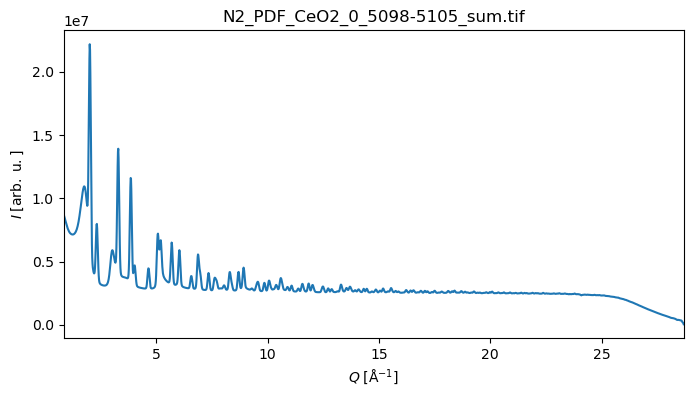

In [12]:
if input_format == "npy":
    data_calib = np.load(input_calib_file)
else:
      data_calib = skimage.io.imread(input_calib_file)
ai = pyFAI.load(str(poni_file))
xy_calib, _integ_setting = integrate(data_calib,
                                     ai=pyFAI.load(str(poni_file)),
                                     mask=np.load(npy_mask_file),
                                     integ_setting=INTEG_SETTING,
                                     )
np.savetxt(output_calib_path / f"{input_calib_file.stem}.{output_format}",
           xy_calib.T,
           header="q[AA^-1]\tI[arb. u]", 
           delimiter="\t",
           encoding="utf-8",
           )
print(f"{80*'-'}\nAzimuthally integrated calibrant data saved to the "
      f"'{output_calib_path.name}' folder.\n{80*'-'}")
x, y = xy_calib
d_calib = dict(x=x, y=y)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_xlim(np.amin(x), np.amax(x))
ax.set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$")
ax.set_ylabel("$I\;[\mathrm{arb.\;u.}]$")
ax.set_title(input_calib_file.name)

Azimuthal integration of background.

--------------------------------------------------------------------------------
Azimuthally integrated data saved to the 'chi_bkg' folder.
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'N2_PDF_NaTFSI_0_5130-5137_sum.tif')

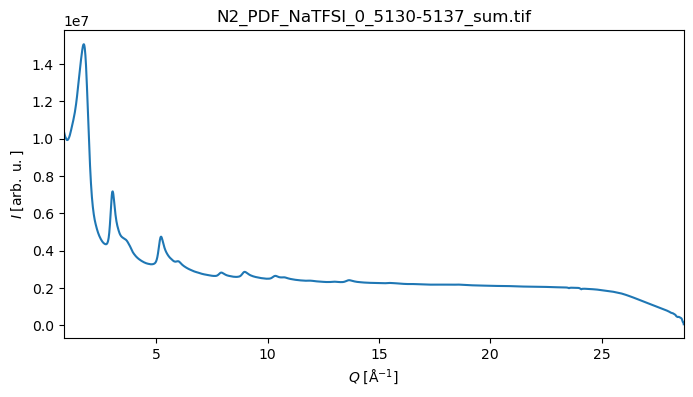

In [13]:
if input_format == "npy":
    data_bkg = np.load(input_bkg_file)
else:
     data_bkg = skimage.io.imread(input_bkg_file)
ai = pyFAI.load(str(poni_file))
xy_bkg, _integ_setting = integrate(data_bkg,
                                   ai=pyFAI.load(str(poni_file)),
                                   mask=np.load(npy_mask_file),
                                   integ_setting=INTEG_SETTING,
                                   )
np.savetxt(output_bkg_path / f"{input_bkg_file.stem}.{output_format}",
           xy_bkg.T,
           header="q[AA^-1]\tI[arb. u]", 
           delimiter="\t",
           encoding="utf-8",
           )
print(f"{80*'-'}\nAzimuthally integrated data saved to the "
      f"'{output_bkg_path.name}' folder.\n{80*'-'}")
x, y = xy_bkg
d_bkg = dict(x=x, y=y)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_xlim(np.amin(x), np.amax(x))
ax.set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$")
ax.set_ylabel("$I\;[\mathrm{arb.\;u.}]$")
ax.set_title(input_bkg_file.name)

Settings used for the automasking.

In [14]:
"""
edge: int, optional
    The number of edge pixels to mask. Defaults to 30. If None, no edge
    mask is applied
lower_thresh: float, optional
    Pixels with values less than or equal to this threshold will be masked.
    Defaults to 0.0. If None, no lower threshold mask is applied
upper_thresh: float, optional
    Pixels with values greater than or equal to this threshold will be
    masked.
    Defaults to None. If None, no upper threshold mask is applied.
alpha: float, optional
    The number of acceptable standard deviations, if tuple then we use
    a linear distribution of alphas from alpha[0] to alpha[1], if array
    then we just use that as the distribution of alphas. Defaults to 3.
    If None, no outlier masking applied.
auto_type: {'median', 'mean'}, optional
    The type of binned outlier masking to be done, 'median' is faster,
    where 'mean' is more accurate, defaults to 'median'.
"""
MASK_SETTING = dict(edge=10, 
                    lower_thresh=0, 
                    upper_thresh=None, 
                    alpha=3,
                    auto_type="mean",
                    )

Automasking the first .tif file and plotting to see whether automasking settings
are appropriate. If not, please edit the mask settings above until appropariate
automasking is observed.

--------------------------------------------------------------------------------
Automasking: 20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum.tif
	mask settings:
		edge	10
		lower_thresh	0
		upper_thresh	None
		alpha	3
		auto_type	mean
Done automasking.


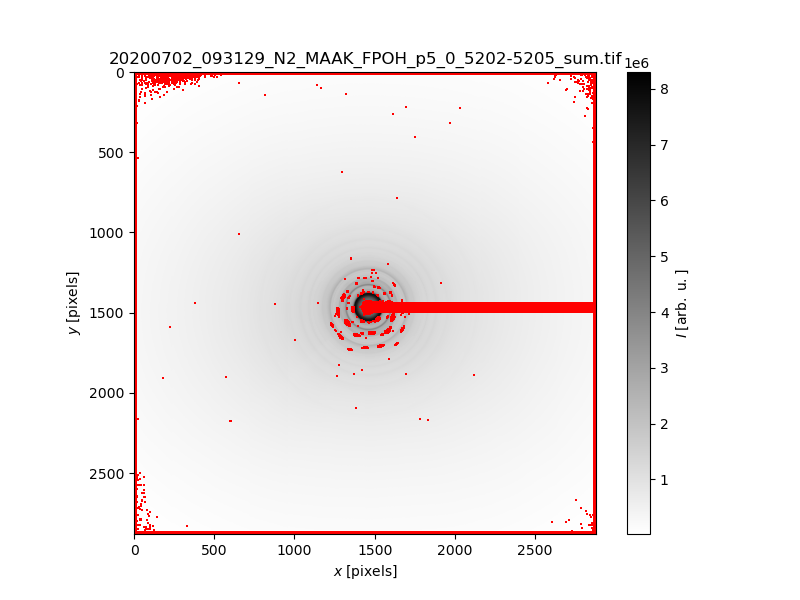

In [15]:
%matplotlib widget

input_file = input_files[0]
print(f"{80*'-'}\nAutomasking: {input_file.name}\n\tmask settings:")
for k, v in MASK_SETTING.items():
    print(f"\t\t{k}\t{v}")
mask_static = np.load(npy_mask_file)
if input_format == "npy":
    data = np.load(input_file)
else:
    data = skimage.io.imread(input_file)
ai = pyFAI.load(str(poni_file))
mask_dynamic = auto_mask(data,
                         ai,
                         1 - mask_static,
                         mask_setting=MASK_SETTING,
                        ) 
data_masked = data * (1 - mask_static) * mask_dynamic
data_masked[data_masked < 1] = -1
data_masked = np.ma.masked_where(data_masked == -1, data_masked)
cmap = mpl.colormaps["binary"]
cmap.set_bad(color="r")
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(data_masked, 
               aspect="equal", 
               cmap=cmap,
               )
ax.set_xlabel("$x\;[\mathrm{pixels}]$")
ax.set_ylabel("$y\;[\mathrm{pixels}]$")
ax.set_title(input_file.name)
cbar = fig.colorbar(im)
cbar.set_label("$I\;[\mathrm{arb.\;u.}]$")
print(f"Done automasking.")

Automasking all .tif files.

In [16]:
print(f"{80*'-'}\nAutomasking .{input_format} files...")
d_data = {}
mask_static = np.load(npy_mask_file)
for i, input_file in enumerate(input_files):
    print(f"\t{i}\t{input_file.name}")
    if input_format == "npy":
        data = np.load(input_file)
    else:
        data = skimage.io.imread(input_file)
    mask_dynamic = auto_mask(img=data,
                             ai=pyFAI.load(str(poni_file)),
                             user_mask=1-mask_static,
                             mask_setting=MASK_SETTING,
                            )
    d_data[i] = dict(input_file=input_file, mask_dynamic=mask_dynamic)
print(f"Done automasking .{input_format} files.\n{80*'-'}")

--------------------------------------------------------------------------------
Automasking .tif files...
	0	20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum.tif
	1	20200702_093338_N2_MAAK_FPOH_p5_1_5226-5229_sum.tif
	2	20200702_093404_N2_MAAK_FPOH_p5_2_5250-5253_sum.tif
	3	20200702_093422_N2_MAAK_FPOH_p5_3_5274-5277_sum.tif
	4	20200702_101425_N2_MAAK_FPOH_p5_0_5287-5290_sum.tif
	5	20200702_101453_N2_MAAK_FPOH_p5_1_5311-5314_sum.tif
	6	20200702_101506_N2_MAAK_FPOH_p5_2_5335-5338_sum.tif
	7	20200702_101521_N2_MAAK_FPOH_p5_3_5359-5362_sum.tif
	8	20200702_101538_N2_MAAK_FPOH_p5_4_5383-5386_sum.tif
	9	20200702_101557_N2_MAAK_FPOH_p5_5_5407-5410_sum.tif
	10	20200702_101610_N2_MAAK_FPOH_p5_6_5431-5434_sum.tif
	11	20200702_101624_N2_MAAK_FPOH_p5_7_5455-5458_sum.tif
	12	20200702_101637_N2_MAAK_FPOH_p5_8_5479-5482_sum.tif
	13	20200702_101653_N2_MAAK_FPOH_p5_9_5503-5506_sum.tif
	14	20200702_101704_N2_MAAK_FPOH_p5_10_5527-5530_sum.tif
	15	20200702_101726_N2_MAAK_FPOH_p5_11_5551-5554_sum.tif
	16	2

If you want to save the dynamic masks from above to `.npy` and `.msk` files,
please run the cell below.  
`Otherwise just skip it, as it might take up quite some memory.`

The .msk format is used by the Fit2D software but can also be used by the DAWN
software package.

In [17]:
npy_mask_dynamic_path = Path.cwd() / "npy_mask_dynamic"
msk_dynamic_path = Path.cwd() / "msk_dynamic"
for p in [npy_mask_dynamic_path, msk_dynamic_path]:
    if not p.exists():
        p.mkdir()
print(f"{80*'-'}\nSaving dynamic masks as .npy and .msk files...")
for i, k in enumerate(d_data.keys()):
    input_file = d_data[k]["input_file"]
    mask_dynamic = d_data[k]["mask_dynamic"]
    print(f"\t{i}\t{input_file.name}")
    np.save(npy_mask_dynamic_path / f"{input_file.stem}_mask",
            1 - mask_dynamic,
            )
    npy_mask_path = npy_mask_dynamic_path / f"{input_file.stem}_mask.npy"
    msk_dynamic_output = msk_dynamic_path / f"{input_file.stem}_mask.msk"
    fabio.open(npy_mask_path).convert("msk").save(msk_dynamic_output)
print(f"Done. Please see the '{npy_mask_dynamic_path.name}' and "
      f"'{msk_dynamic_path.name}' folders.\n{80*'-'}")

--------------------------------------------------------------------------------
Saving dynamic masks as .npy and .msk files...
	0	20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum.tif
	1	20200702_093338_N2_MAAK_FPOH_p5_1_5226-5229_sum.tif
	2	20200702_093404_N2_MAAK_FPOH_p5_2_5250-5253_sum.tif
	3	20200702_093422_N2_MAAK_FPOH_p5_3_5274-5277_sum.tif
	4	20200702_101425_N2_MAAK_FPOH_p5_0_5287-5290_sum.tif
	5	20200702_101453_N2_MAAK_FPOH_p5_1_5311-5314_sum.tif
	6	20200702_101506_N2_MAAK_FPOH_p5_2_5335-5338_sum.tif
	7	20200702_101521_N2_MAAK_FPOH_p5_3_5359-5362_sum.tif
	8	20200702_101538_N2_MAAK_FPOH_p5_4_5383-5386_sum.tif
	9	20200702_101557_N2_MAAK_FPOH_p5_5_5407-5410_sum.tif
	10	20200702_101610_N2_MAAK_FPOH_p5_6_5431-5434_sum.tif
	11	20200702_101624_N2_MAAK_FPOH_p5_7_5455-5458_sum.tif
	12	20200702_101637_N2_MAAK_FPOH_p5_8_5479-5482_sum.tif
	13	20200702_101653_N2_MAAK_FPOH_p5_9_5503-5506_sum.tif
	14	20200702_101704_N2_MAAK_FPOH_p5_10_5527-5530_sum.tif
	15	20200702_101726_N2_MAAK_FPOH_p5_11_55

Integration and plotting of the first input data file to see, whether the 
integration settings are appropriate.  
If not, please edit the integration settings above, until appropriate 
integration is obtained.

--------------------------------------------------------------------------------
Integrating 20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum.tif
Done integrating.
--------------------------------------------------------------------------------


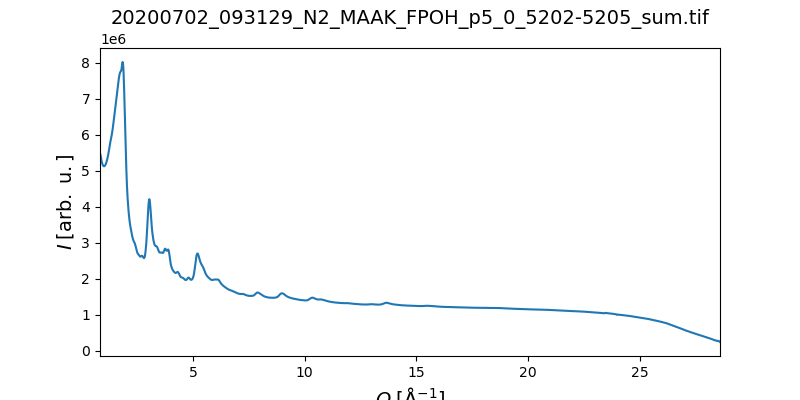

In [18]:
keys = list(d_data.keys())
input_file = d_data[keys[0]]["input_file"]
mask = d_data[keys[0]]["mask_dynamic"]
print(f"{80*'-'}\nIntegrating {input_file.name}")
if input_format == "npy":
    data = np.load(input_file)
else:
    skimage.io.imread(input_file)
xy_data, _integ_setting = integrate(data,
                                    ai=pyFAI.load(str(poni_file)),
                                    mask=1-mask,
                                    integ_setting=INTEG_SETTING,
                                    )
x, y = xy_data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_xlim(np.amin(x), np.amax(x))
ax.set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=14)
ax.set_ylabel("$I\;[\mathrm{arb.\;u.}]$", fontsize=14)
ax.set_title(input_file.name, fontsize=14)
print(f"Done integrating.\n{80*'-'}")

Integrating all input files.

In [19]:
print(f"{80*'-'}\nAzimuthally integrating .{input_format} files to "
      f".{output_format} files...")
for i, k in enumerate(d_data.keys()):
    input_file = d_data[k]["input_file"]
    mask = d_data[k]["mask_dynamic"]
    print(f"\t{i}\t{input_file.name}")
    if input_format == "npy":
        data = np.load(input_file)
    else:
        data = skimage.io.imread(input_file)
    xy_data, _integ_setting = integrate(data,
                                        ai=pyFAI.load(str(poni_file)),
                                        mask=1-mask,
                                        integ_setting=INTEG_SETTING,
                                        )
    d_data[k]["x"], d_data[k]["y"] = xy_data
    np.savetxt(output_path / f"{input_file.stem}.{output_format}", 
               xy_data.T,
               header="q[AA^-1]\tI[arb. u]", 
               delimiter="\t",
               encoding="utf-8",
               )
print(f"Done integrating .{input_format} files. Please see the "
      f"{output_path.name} folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Azimuthally integrating .tif files to .chi files...
	0	20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum.tif
	1	20200702_093338_N2_MAAK_FPOH_p5_1_5226-5229_sum.tif
	2	20200702_093404_N2_MAAK_FPOH_p5_2_5250-5253_sum.tif
	3	20200702_093422_N2_MAAK_FPOH_p5_3_5274-5277_sum.tif
	4	20200702_101425_N2_MAAK_FPOH_p5_0_5287-5290_sum.tif
	5	20200702_101453_N2_MAAK_FPOH_p5_1_5311-5314_sum.tif
	6	20200702_101506_N2_MAAK_FPOH_p5_2_5335-5338_sum.tif
	7	20200702_101521_N2_MAAK_FPOH_p5_3_5359-5362_sum.tif
	8	20200702_101538_N2_MAAK_FPOH_p5_4_5383-5386_sum.tif
	9	20200702_101557_N2_MAAK_FPOH_p5_5_5407-5410_sum.tif
	10	20200702_101610_N2_MAAK_FPOH_p5_6_5431-5434_sum.tif
	11	20200702_101624_N2_MAAK_FPOH_p5_7_5455-5458_sum.tif
	12	20200702_101637_N2_MAAK_FPOH_p5_8_5479-5482_sum.tif
	13	20200702_101653_N2_MAAK_FPOH_p5_9_5503-5506_sum.tif
	14	20200702_101704_N2_MAAK_FPOH_p5_10_5527-5530_sum.tif
	15	20200702_101726_N2_MAAK_FPOH_p5_

Plotting azimuthally integrated background and data together.

`Please use the plot to inspect, which Q-range ('xmin' and 'xmax' below) to base
the normalization/scaling on to account for beam intensity fluctuations.`

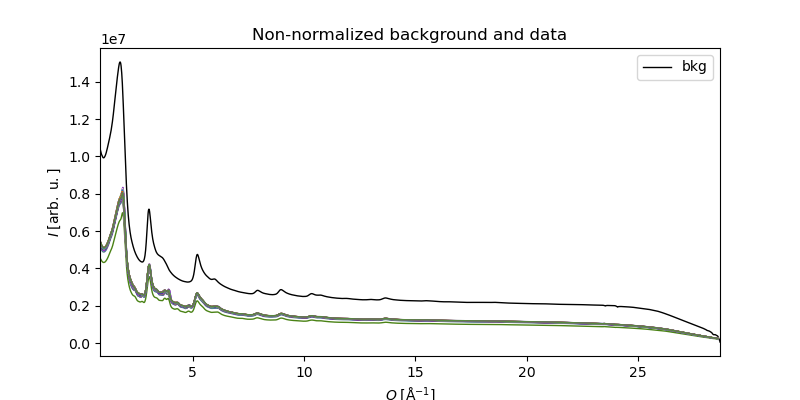

In [20]:
keys = list(d_data.keys())
cmap = mpl.colormaps["hsv"]
cmap_idx = np.linspace(0, 1, len(keys))
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_bkg["x"], d_bkg["y"], c="k", lw=1, label="bkg")
for i, k in enumerate(keys):
    ax.plot(d_data[k]["x"], d_data[k]["y"], c=np.random.rand(3,), lw=1)
ax.set_xlim(np.amin(d_bkg["x"]), np.amax(d_bkg["x"]))
ax.set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$")
ax.set_ylabel("$I\;[\mathrm{arb.\;u.}]$")
ax.set_title("Non-normalized background and data")
ax.legend()

Minimum and maximum $Q$-value to base the normalization/scaling on to account
for beam intensity fluctuations.

In [21]:
xmin, xmax = 0.9, 1.0

Creating folders for output files with estimated standard deviations (esd).

In [22]:
data_esd_path = Path.cwd() / f"{output_format}_esd"
bkg_esd_path = Path.cwd() / f"{output_format}_bkg_esd"
calib_esd_path = Path.cwd() / f"{output_format}_calib_esd"
for p in [data_esd_path, bkg_esd_path, calib_esd_path]:
    if not p.exists():
        p.mkdir()

Function to estimate standard deviations and writing to files.

In [23]:
def esd_calc_write(filename, x, y, wl, sdd, output_path):
    x_rad = q_to_twotheta(x, wl)
    normalizer = np.array([2*np.pi*sdd*np.tan(x_rad[i])/0.150
                           for i in range(len(x_rad))])
    esd = np.sqrt(y / normalizer)
    xye = np.column_stack((x, y, esd))
    name, suffix = filename.split(".")
    output_name = f"{name}_esd.{suffix}"
    np.savetxt(output_path / output_name,
               xye,
               fmt="%.18e",
               delimiter="\t",
               encoding="utf-8",
               )

    return xye, output_path / output_name

Loading wavelength (wl) and sample-detector-distance (sdd) (in meters) from 
`.poni` file from calibration.  
Converting wl to Ångström (Å) and sdd to millimeters (mm).

In [24]:
ai = pyFAI.load(str(poni_file))
wl, sdd = ai.wavelength * 10**10, ai.dist * 10**3
print(f"{80*'-'}\nwl: {wl} Å\nsdd: {sdd} mm\n{80*'-'}")

--------------------------------------------------------------------------------
wl: 0.20696 Å
sdd: 207.22743871696258 mm
--------------------------------------------------------------------------------


Estimating esd for calibrant and writing to file.

In [25]:
output_calib_file = list(output_calib_path.glob(f"*.{output_format}"))[0]
print(f"{80*'-'}\nWriting esds for calibrant...")
d_calib["xye"], d_calib["esd_path"] = esd_calc_write(output_calib_file.name,
                                                     d_calib["x"],
                                                     d_calib["y"],
                                                     wl,
                                                     sdd,
                                                     calib_esd_path,
                                                     )
print(f"Done. Please see the '{calib_esd_path.name}' folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Writing esds for calibrant...
Done. Please see the 'chi_calib_esd' folder.
--------------------------------------------------------------------------------


Estimating esd for background and writing to file.

In [26]:
output_bkg_file = list(output_bkg_path.glob(f"*.{output_format}"))[0]
print(f"{80*'-'}\nWriting esds for bkg...")
d_bkg["xye"], d_bkg["esd_path"] = esd_calc_write(output_bkg_file.name,
                                                 d_bkg["x"],
                                                 d_bkg["y"],
                                                 wl,
                                                 sdd,
                                                 bkg_esd_path,
                                                 )
print(f"Done. Please see the '{bkg_esd_path.name}' folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Writing esds for bkg...
Done. Please see the 'chi_bkg_esd' folder.
--------------------------------------------------------------------------------


Estimating esd for data files and writing to files.

In [27]:
print(f"{80*'-'}\nCalculating esds and writing to files...")
for i, k in enumerate(d_data.keys()):
    input_file, x, y = d_data[k]["input_file"], d_data[k]["x"], d_data[k]["y"]
    input_file = output_path / f"{input_file.stem}.{output_format}"
    print(f"\t{i}\t{input_file.stem}_esd{input_file.suffix}")
    d_data[k]["xye"], d_data[k]["esd_path"] = esd_calc_write(input_file.name, 
                                                             x, 
                                                             y, 
                                                             wl, 
                                                             sdd, 
                                                             data_esd_path,
                                                             )
print(f"Done. Please see the '{data_esd_path.name}' folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Calculating esds and writing to files...
	0	20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum_esd.chi
	1	20200702_093338_N2_MAAK_FPOH_p5_1_5226-5229_sum_esd.chi
	2	20200702_093404_N2_MAAK_FPOH_p5_2_5250-5253_sum_esd.chi
	3	20200702_093422_N2_MAAK_FPOH_p5_3_5274-5277_sum_esd.chi
	4	20200702_101425_N2_MAAK_FPOH_p5_0_5287-5290_sum_esd.chi
	5	20200702_101453_N2_MAAK_FPOH_p5_1_5311-5314_sum_esd.chi
	6	20200702_101506_N2_MAAK_FPOH_p5_2_5335-5338_sum_esd.chi
	7	20200702_101521_N2_MAAK_FPOH_p5_3_5359-5362_sum_esd.chi
	8	20200702_101538_N2_MAAK_FPOH_p5_4_5383-5386_sum_esd.chi
	9	20200702_101557_N2_MAAK_FPOH_p5_5_5407-5410_sum_esd.chi
	10	20200702_101610_N2_MAAK_FPOH_p5_6_5431-5434_sum_esd.chi
	11	20200702_101624_N2_MAAK_FPOH_p5_7_5455-5458_sum_esd.chi
	12	20200702_101637_N2_MAAK_FPOH_p5_8_5479-5482_sum_esd.chi
	13	20200702_101653_N2_MAAK_FPOH_p5_9_5503-5506_sum_esd.chi
	14	20200702_101704_N2_MAAK_FPOH_p5_10_5527-5530

Creating output folders for normalized background and data files.

In [28]:
data_esd_norm_path = Path.cwd() / f"{output_format}_esd_norm"
bkg_esd_norm_path = Path.cwd() / f"{output_format}_bkg_esd_norm"
for p in [data_esd_norm_path, bkg_esd_norm_path]:
    if not p.exists():
        p.mkdir()

Function definitions used for normalization/scaling of background and data 
files.

In [29]:
def basecase_calc(x, y, xmin, xmax):
    basecase = 0
    for i in range(len(x)):
        if xmin <= x[i] <= xmax:
            basecase += y[i]

    return basecase


def norm_factor(x, y, basecase, xmin, xmax):
    intensity, intensity_sum = 0, 0
    for i in range(len(y)):
        if xmin <= x[i] <= xmax:
            intensity_sum += y[i]
    if intensity_sum == 0:
        normalizer = 1
    else:
        normalizer = basecase / intensity_sum

    return normalizer


def normalizer(intput_file, xye, basecase, xmin, xmax, output_path):
    x, y, e = xye.T
    factor = norm_factor(x, y, basecase, xmin, xmax)
    y_norm, e_norm = y * factor, e * factor
    xye_norm = np.column_stack((x, y_norm, e_norm))
    output_name = f"{input_file.stem}_esd_norm{input_file.suffix}"
    np.savetxt(output_path / output_name,
               xye_norm,
               fmt="%.18e",
               delimiter="\t",
               encoding="utf-8",
               )

    return xye_norm

Normalization/scaling of data files.

In [30]:
print(f"{80*'-'}\nNormalizing data files...")
for i, k in enumerate(d_data.keys()):
    input_file, xye = d_data[k]["esd_path"], d_data[k]["xye"]
    print(f"\t{i}\t{d_data[k]['esd_path'].name}")
    x, y, e = xye.T
    if i == 0:
        basecase = basecase_calc(x, y, xmin, xmax)
    d_data[k]["xye_norm"] = normalizer(input_file, 
                                       xye, 
                                       basecase, 
                                       xmin, 
                                       xmax, 
                                       data_esd_norm_path,
                                       )
print(f"Done. Please see the '{data_esd_norm_path.name}' folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Normalizing data files...
	0	20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum_esd.chi
	1	20200702_093338_N2_MAAK_FPOH_p5_1_5226-5229_sum_esd.chi
	2	20200702_093404_N2_MAAK_FPOH_p5_2_5250-5253_sum_esd.chi
	3	20200702_093422_N2_MAAK_FPOH_p5_3_5274-5277_sum_esd.chi
	4	20200702_101425_N2_MAAK_FPOH_p5_0_5287-5290_sum_esd.chi
	5	20200702_101453_N2_MAAK_FPOH_p5_1_5311-5314_sum_esd.chi
	6	20200702_101506_N2_MAAK_FPOH_p5_2_5335-5338_sum_esd.chi
	7	20200702_101521_N2_MAAK_FPOH_p5_3_5359-5362_sum_esd.chi
	8	20200702_101538_N2_MAAK_FPOH_p5_4_5383-5386_sum_esd.chi
	9	20200702_101557_N2_MAAK_FPOH_p5_5_5407-5410_sum_esd.chi
	10	20200702_101610_N2_MAAK_FPOH_p5_6_5431-5434_sum_esd.chi
	11	20200702_101624_N2_MAAK_FPOH_p5_7_5455-5458_sum_esd.chi
	12	20200702_101637_N2_MAAK_FPOH_p5_8_5479-5482_sum_esd.chi
	13	20200702_101653_N2_MAAK_FPOH_p5_9_5503-5506_sum_esd.chi
	14	20200702_101704_N2_MAAK_FPOH_p5_10_5527-5530_sum_esd.chi
	1

Normalization/scaling of background file.

In [31]:
print(f"{80*'-'}\nNormalizing background file...\n\t{d_bkg['esd_path'].name}")
input_file, xye = d_bkg["esd_path"], d_bkg["xye"]
x, y, e = xye.T
d_bkg["xye_norm"] = normalizer(input_file, 
                               xye, 
                               basecase, 
                               xmin, 
                               xmax, 
                               bkg_esd_norm_path,
                               )
print(f"Done. Please see the '{bkg_esd_norm_path.name}' folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Normalizing background file...
	N2_PDF_NaTFSI_0_5130-5137_sum_esd.chi
Done. Please see the 'chi_bkg_esd_norm' folder.
--------------------------------------------------------------------------------


Creating output folders for plots.

In [32]:
plot_folders = ["png", "pdf", "svg"]
plot_paths = [Path.cwd() / folder for folder in plot_folders]
for p in plot_paths:
    if not p.exists():
        p.mkdir()

Plotting normalized/scaled background and data files together.

--------------------------------------------------------------------------------
Plotting normalized/scaled background and data files together.
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


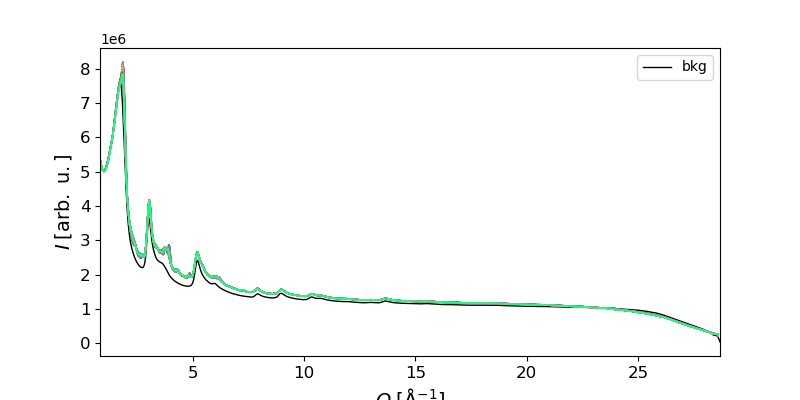

In [33]:
print(f"{80*'-'}\nPlotting normalized/scaled background and data files "
      f"together.")
keys = list(d_data.keys())
fig, ax = plt.subplots(figsize=(8, 4))
x_bkg, y_bkg, e_bkg = d_bkg["xye_norm"].T
ax.plot(x_bkg, y_bkg, c="k", lw=1, label="bkg")
for i, k in enumerate(keys):
    x, y, e = d_data[k]["xye_norm"].T
    ax.plot(x, y, c=np.random.rand(3,), lw=1)
ax.set_xlim(np.amin(x_bkg), np.amax(x_bkg))
ax.set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=14)
ax.set_ylabel("$I\;[\mathrm{arb.\;u.}]$", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.legend()
for p in plot_paths:
    print(f"\t{p.name}")
    plt.savefig(p / f"data_bkg_norm.{p.name}", bbox_inches="tight", dpi=600)
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Overview plot for full Q-range.

--------------------------------------------------------------------------------
Overview plot for full Q-range...
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


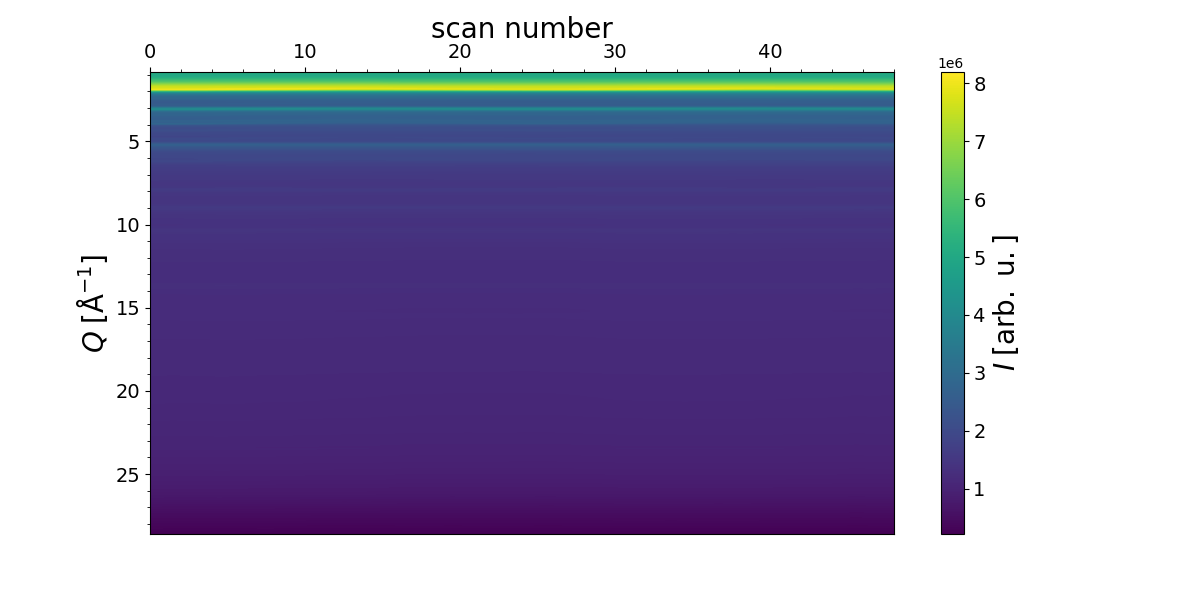

In [62]:
print(f"{80*'-'}\nOverview plot for full Q-range...")
for i, k in enumerate(d_data.keys()):
    x, y, e = d_data[k]["xye_norm"].T
    if i == 0:
        x_array = x
        y_array = y        
    else:
        y_array = np.column_stack((y_array, y))
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(y_array,
               aspect="auto", 
               extent=(0, 
                       len(d_data.keys()), 
                       np.amax(x_array), 
                       np.amin(x_array)),
                       )
ax.tick_params(axis="x",
               which="both",
               top=True,
               labeltop=True,
               bottom=False,
               labelbottom=False,
               )
ax.tick_params(axis="both", labelsize=14)
ax.minorticks_on()
ax.set_xlabel("scan number", fontsize=20)
ax.xaxis.set_label_position("top")
ax.set_ylabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=20)
cbar = plt.colorbar(im)
cbar.set_label("$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
cbar.ax.tick_params(labelsize=14)
cbar.formatter.set_powerlimits((0, 0))
for p in plot_paths:
    print(f"\t{p.name}")
    plt.savefig(p / f"data_overview_full.{p.name}", 
                bbox_inches="tight", 
                dpi=600,
                )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

In [63]:
xmin_plot, xmax_plot = 2.5, 7.5

--------------------------------------------------------------------------------
Plotting overview plot from 2.5 to 7.5 Å^-1...
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


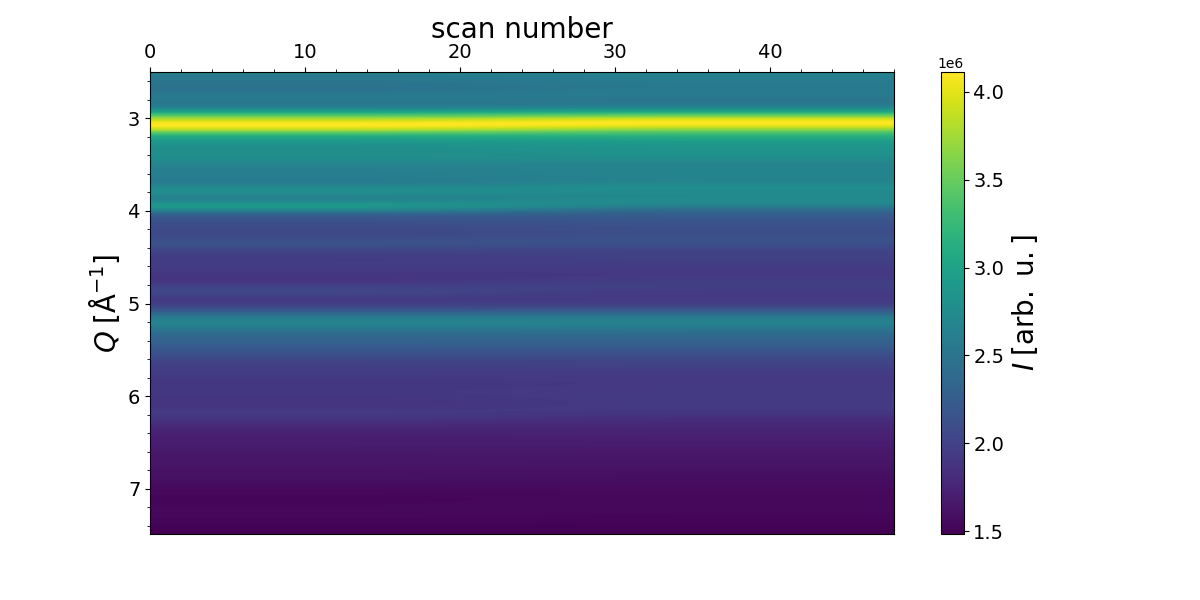

In [65]:
print(f"{80*'-'}\nPlotting overview plot from {xmin_plot} to {xmax_plot} "
      f"Å^-1...")
xmin_idx, xmax_idx = 0, -1
keys = list(d_data.keys())
for i, x in enumerate(d_data[keys[0]]["x"]):
    if xmin_plot <= x:
        xmin_idx = i
        break
for i, x in enumerate(d_data[keys[0]]["x"]):
    if xmax_plot <= x:
        xmax_idx = i
        break
for i, k in enumerate(d_data.keys()):
    x, y, e = d_data[k]["xye_norm"].T
    if i == 0:
        x_array = x[xmin_idx:xmax_idx]
        y_array = y[xmin_idx:xmax_idx]
    else:
        y = np.column_stack((y_array, y[xmin_idx:xmax_idx]))
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(y,
               aspect="auto", 
               extent=(0, 
                       len(d_data.keys()), 
                       np.amax(x_array), 
                       np.amin(x_array)
                       ),
               )
ax.tick_params(axis="x",
               which="both",
               top=True,
               labeltop=True,
               bottom=False,
               labelbottom=False,
               )
ax.tick_params(axis="both", labelsize=14)
ax.minorticks_on()
ax.set_xlabel("scan number", fontsize=20)
ax.xaxis.set_label_position("top")
ax.set_ylabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=20)
cbar = plt.colorbar(im)
cbar.set_label("$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
cbar.ax.tick_params(labelsize=14)
cbar.formatter.set_powerlimits((0, 0))
for p in plot_paths:
    print(f"\t{p.name}")
    plt.savefig(p / f"data_overview_{xmin_plot}-{xmax_plot}.{p.name}", 
                bbox_inches="tight", 
                dpi=600,
                )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

Function definition to obtain scale factor for background to avoid negative 
intensities for background-subtracted data files.

In [66]:
def bkg_scale_factor(d_data, d_bkg):
    bkg_scale_list = []
    bkg_scale = 1
    x_bkg, y_bkg, e_bkg = d_bkg["xye_norm"].T
    for k in d_data.keys():
        x, y, e = d_data[k]["xye_norm"].T
        y_bkg = bkg_scale * y_bkg
        bool_list = y >= y_bkg
        while False in bool_list:
            bkg_scale = bkg_scale * 0.999
            y_bkg = bkg_scale * y_bkg
            bool_list = y >= y_bkg
        bkg_scale_list.append(bkg_scale)

    return min(bkg_scale_list)

Obtaining background scale factor and writing it to `.txt` file.

In [67]:
print(f"{80*'-'}\nObtaining scale factor for background...")
bkg_scale = bkg_scale_factor(d_data, d_bkg)
bkg_scale_output = Path.cwd() / "bkg_scale.txt"
with bkg_scale_output.open(mode="w") as o:
    o.write(f"bkgscale\t{bkg_scale}\n")
print(f"\tbkg_scale: {bkg_scale}\nWritten to {bkg_scale_output.name}."
      f"\n{80*'-'}")

--------------------------------------------------------------------------------
Obtaining scale factor for background...
	bkg_scale: 0.9890548353295385
Written to bkg_scale.txt.
--------------------------------------------------------------------------------


Creating output path for background-subtracted data files.

In [68]:
data_esd_norm_bkgsub_path = Path.cwd() / f"{output_format}_esd_norm_bkgsub"
if not data_esd_norm_bkgsub_path.exists():
    data_esd_norm_bkgsub_path.mkdir()

Subtracting scaled background from data and writing to files.

In [69]:
print(f"{80*'-'}\nSubtracting background from data...")
x_bkg, y_bkg, e_bkg = d_bkg["xye_norm"].T
y_bkg_scaled = bkg_scale * y_bkg
for i, k in enumerate(d_data.keys()):
    print(f"\t{i}\t{d_data[k]['input_file'].stem}.{output_format}")
    x, y, e = d_data[k]["xye_norm"].T
    y_bkgsub = y - y_bkg_scaled
    d_data[k]["y_bkgsub"] = y_bkgsub
    outputname = f"{d_data[k]['input_file'].stem}.{output_format}" 
    np.savetxt(data_esd_norm_bkgsub_path / outputname,
               np.column_stack((x, y_bkgsub, e)),
               fmt="%.18e",
               delimiter="\t",
               encoding="utf-8",
               )
print(f"Done. Please see the '{data_esd_norm_bkgsub_path.name}' folder."
      f"\n{80*'-'}")

--------------------------------------------------------------------------------
Subtracting background from data...
	0	20200702_093129_N2_MAAK_FPOH_p5_0_5202-5205_sum.chi
	1	20200702_093338_N2_MAAK_FPOH_p5_1_5226-5229_sum.chi
	2	20200702_093404_N2_MAAK_FPOH_p5_2_5250-5253_sum.chi
	3	20200702_093422_N2_MAAK_FPOH_p5_3_5274-5277_sum.chi
	4	20200702_101425_N2_MAAK_FPOH_p5_0_5287-5290_sum.chi
	5	20200702_101453_N2_MAAK_FPOH_p5_1_5311-5314_sum.chi
	6	20200702_101506_N2_MAAK_FPOH_p5_2_5335-5338_sum.chi
	7	20200702_101521_N2_MAAK_FPOH_p5_3_5359-5362_sum.chi
	8	20200702_101538_N2_MAAK_FPOH_p5_4_5383-5386_sum.chi
	9	20200702_101557_N2_MAAK_FPOH_p5_5_5407-5410_sum.chi
	10	20200702_101610_N2_MAAK_FPOH_p5_6_5431-5434_sum.chi
	11	20200702_101624_N2_MAAK_FPOH_p5_7_5455-5458_sum.chi
	12	20200702_101637_N2_MAAK_FPOH_p5_8_5479-5482_sum.chi
	13	20200702_101653_N2_MAAK_FPOH_p5_9_5503-5506_sum.chi
	14	20200702_101704_N2_MAAK_FPOH_p5_10_5527-5530_sum.chi
	15	20200702_101726_N2_MAAK_FPOH_p5_11_5551-5554_sum

Plotting background-subtracted data files together.

--------------------------------------------------------------------------------
Plotting background-subtracted data files together...
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folder.
--------------------------------------------------------------------------------


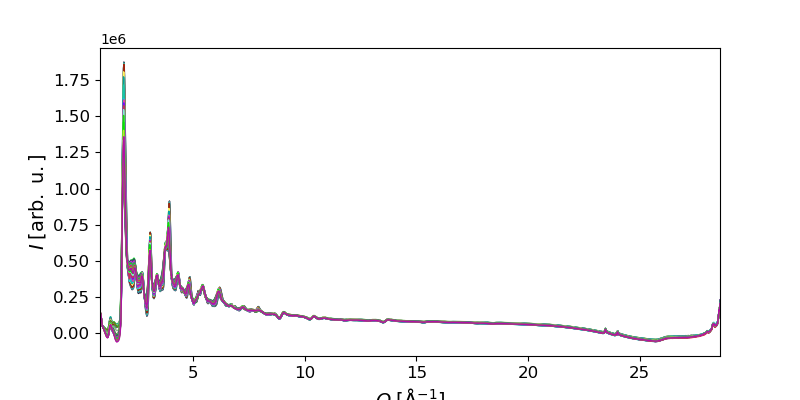

In [70]:
print(f"{80*'-'}\nPlotting background-subtracted data files together...")
keys = list(d_data.keys())
fig, ax = plt.subplots(figsize=(8, 4))
for i, k in enumerate(keys):
    ax.plot(d_data[k]["x"], d_data[k]["y_bkgsub"], c=np.random.rand(3,), lw=1)
ax.set_xlim(np.amin(d_data[k]["x"]), np.amax(d_data[k]["x"]))
ax.set_xlabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=14)
ax.set_ylabel("$I\;[\mathrm{arb.\;u.}]$", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
for p in plot_paths:
    print(f"\t{p.name}")
    plt.savefig(p / f"data_bkgsub.{p.name}", bbox_inches="tight", dpi=600)
print(f"Done. Please see the {plot_folders} folder.\n{80*'-'}")  

Overview plot for background-subtracted data and full Q-range.

--------------------------------------------------------------------------------
Overview plot for background-subtracted data and full Q-range...
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


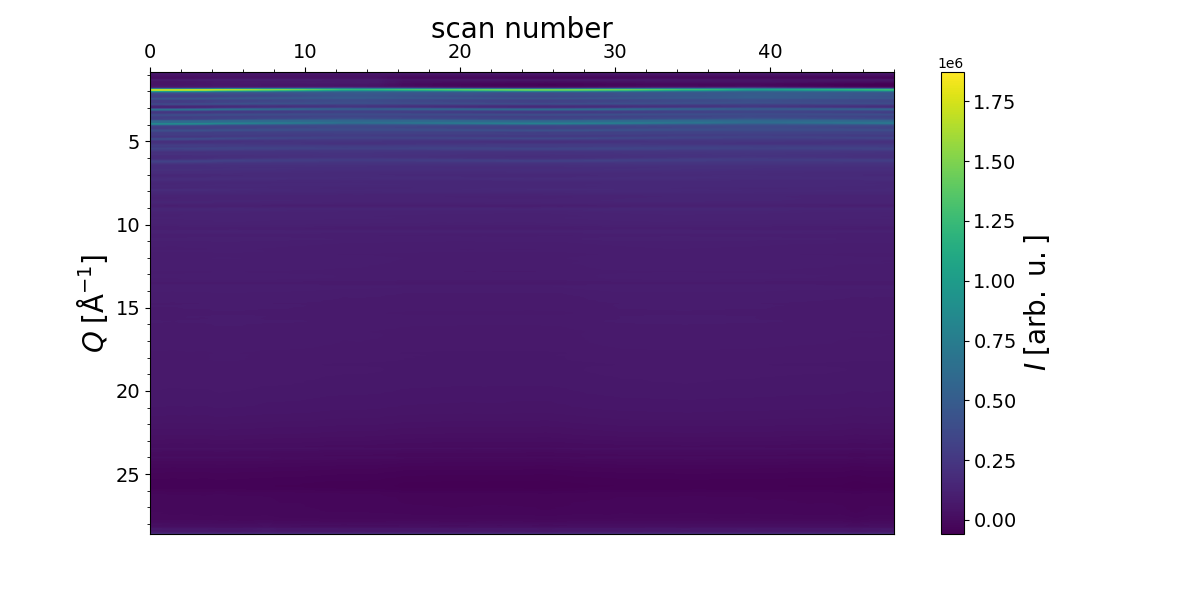

In [71]:
print(f"{80*'-'}\nOverview plot for background-subtracted data and full "
      f"Q-range...")
for i, k in enumerate(d_data.keys()):
    if i == 0:
        y = d_data[k]["y_bkgsub"]
        x = d_data[k]["x"]
    else:
        y = np.column_stack((y, d_data[k]["y_bkgsub"]))
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(y, 
               aspect="auto", 
               extent=(0, len(d_data.keys()), np.amax(x), np.amin(x)),
               )
ax.tick_params(axis="x",
               which="both",
               top=True,
               labeltop=True,
               bottom=False,
               labelbottom=False,
               )
ax.tick_params(axis="both", labelsize=14)
ax.minorticks_on()
ax.set_xlabel("scan number", fontsize=20)
ax.xaxis.set_label_position("top")
ax.set_ylabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=20)
cbar = plt.colorbar(im)
cbar.set_label("$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
cbar.ax.tick_params(labelsize=14)
cbar.formatter.set_powerlimits((0, 0))
for p in plot_paths:
    print(f"\t{p.name}")
    plt.savefig(p / f"data_bkgsub_overview_full.{p.name}", 
                bbox_inches="tight", 
                dpi=600,
                )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

To improve contrast in the overview plots, please specify minimum and maximum
Q-values to include in the overview plot.

In [72]:
xmin_plot, xmax_plot = 2.5, 7.5

Overview plot for background-subtracted data and specified Q-range.

--------------------------------------------------------------------------------
Plotting overview plot from 2.5 to 7.5 Å^-1...
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------


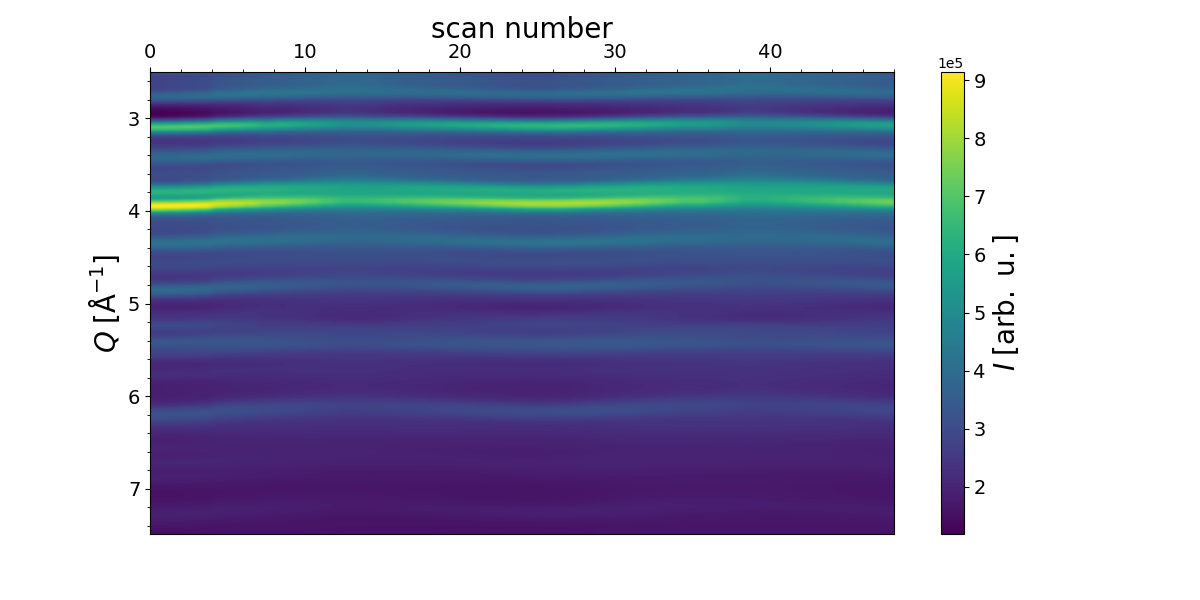

In [73]:
print(f"{80*'-'}\nPlotting overview plot from {xmin_plot} to {xmax_plot} "
      f"Å^-1...")
xmin_idx, xmax_idx = 0, -1
keys = list(d_data.keys())
for i, x in enumerate(d_data[keys[0]]["x"]):
    if xmin_plot <= x:
        xmin_idx = i
        break
for i, x in enumerate(d_data[keys[0]]["x"]):
    if xmax_plot <= x:
        xmax_idx = i
        break
for i, k in enumerate(d_data.keys()):
    if i == 0:
        y = d_data[k]["y_bkgsub"][xmin_idx:xmax_idx]
        x = d_data[k]["x"][xmin_idx:xmax_idx]
    else:
        y = np.column_stack((y, d_data[k]["y_bkgsub"][xmin_idx:xmax_idx]))
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(y, 
               aspect="auto", 
               extent=(0, len(d_data.keys()), np.amax(x), np.amin(x)),
               )
ax.tick_params(axis="x",
               which="both",
               top=True,
               labeltop=True,
               bottom=False,
               labelbottom=False,
               )
ax.tick_params(axis="both", labelsize=14)
ax.minorticks_on()
ax.set_xlabel("scan number", fontsize=20)
ax.xaxis.set_label_position("top")
ax.set_ylabel("$Q\;[\mathrm{\AA}^{-1}]$", fontsize=20)
cbar = plt.colorbar(im)
cbar.set_label("$I\;[\mathrm{arb.\;u.}]$", fontsize=20)
cbar.ax.tick_params(labelsize=14)
cbar.formatter.set_powerlimits((0, 0))
for p in plot_paths:
    print(f"\t{p.name}")
    plt.savefig(p / f"data_bkgsub_overview_{xmin_plot}-{xmax_plot}.{p.name}", 
                bbox_inches="tight", 
                dpi=600,
                )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")